In [617]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/faceforensics1600-videospreprocess/data/val/fake/1581_0.jpg
/kaggle/input/faceforensics1600-videospreprocess/data/val/fake/1454_0.jpg
/kaggle/input/faceforensics1600-videospreprocess/data/val/fake/3572_0.jpg
/kaggle/input/faceforensics1600-videospreprocess/data/val/fake/7525_0.jpg
/kaggle/input/faceforensics1600-videospreprocess/data/val/fake/5537_0.jpg
/kaggle/input/faceforensics1600-videospreprocess/data/val/fake/1485_2.jpg
/kaggle/input/faceforensics1600-videospreprocess/data/val/fake/1535_0.jpg
/kaggle/input/faceforensics1600-videospreprocess/data/val/fake/1548_0.jpg
/kaggle/input/faceforensics1600-videospreprocess/data/val/fake/1560_0.jpg
/kaggle/input/faceforensics1600-videospreprocess/data/val/fake/5533_0.jpg
/kaggle/input/faceforensics1600-videospreprocess/data/val/fake/7581_0.jpg
/kaggle/input/faceforensics1600-videospreprocess/data/val/fake/5455_0.jpg
/kaggle/input/faceforensics1600-videospreprocess/data/val/fake/5463_0.jpg
/kaggle/input/faceforensics1600-videos

In [618]:
# !pip install wandb

In [619]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.applications import Xception,xception
from PIL import Image
import matplotlib.pyplot as plt
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint


print("Libraries Imported")

Libraries Imported


In [620]:
lr_schedule = starter_learning_rate = 0.1
end_learning_rate = 5e-5
decay_steps = 10000
learning_rate_fn = PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=0.5)

In [621]:
# Define your optimizer and learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Start a run, tracking hyperparameters
run = wandb.init(
    # set the wandb project where this run will be logged
    project="DeepFake Detection",
    # track hyperparameters and run metadata with wandb.config
    config={
        "optimizer": "adam",  # Use the string identifier for the optimizer
        "optimizer_config": optimizer.get_config(),  # Pass the optimizer configuration,
        "loss": "binary_crossentropy",
        "metric": "accuracy",
        "epoch": 20,
        "batch_size": 32,
    },
)

batch/accuracy,▅▃▄█▆▅▅▅▄▃▄▅▄▄▃▂▁▂▂▁
batch/batch_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
batch/accuracy,0.48079
batch/batch_step,95
batch/loss,nan


In [622]:
config = wandb.config

In [623]:
import tensorflow as tf

# Check for GPU availability
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
    # Enable mixed precision for better performance
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
else:
    print("GPU is not available")

GPU is available


In [624]:
# Using Image Data Generator to create a tf.data.Dataset

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=10,
    shear_range=0.2,
    zoom_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Using the generator created above, we will use it to generate data from our directory

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/faceforensics1600-videospreprocess/data/train',
    target_size=(299, 299),
    batch_size=config.batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    '/kaggle/input/faceforensics1600-videospreprocess/data/val',
    target_size=(299, 299),
    batch_size=config.batch_size,
    class_mode='binary'
)

test_generator = val_datagen.flow_from_directory(
    '/kaggle/input/faceforensics1600-videospreprocess/data/test',
    target_size = (299,299),
    batch_size = config.batch_size,
    class_mode = 'binary')


Found 11448 images belonging to 2 classes.
Found 1257 images belonging to 2 classes.
Found 3103 images belonging to 2 classes.


In [625]:
import matplotlib.pyplot as plt
import seaborn as sns

(32, 299, 299, 3)


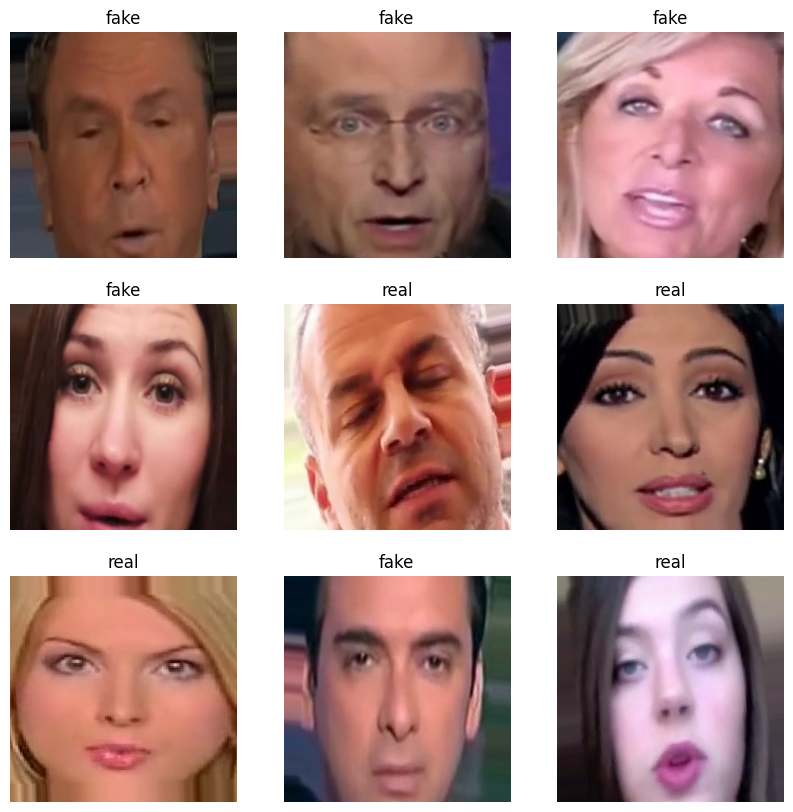

In [626]:
# Get the class names
class_names = train_generator.class_indices
class_names = dict((v, k) for k, v in class_names.items())

# Take a batch of images and labels
images, labels = next(iter(train_generator))
print(images.shape)
# Create a figure and plot the images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[labels[i]])
    plt.axis("off")

plt.show()

In [627]:
from tensorflow.keras.layers import SeparableConv2D,BatchNormalization,Conv2D,ReLU,MaxPooling2D,GlobalAveragePooling2D,Dense,Softmax,Add,Dropout
from tensorflow.keras.layers import RandomFlip, RandomRotation,Rescaling,Reshape
from tensorflow.keras.models import Model, load_model


In [628]:
def data_augmentor():
    """Augment the data by applying Flipping and Rotations to the Image"""
    data_aug = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.05)
    ], name="data_augmentation")
    return data_aug

In [629]:
# AUTOTUNE = tf.data.AUTOTUNE
# train_generator = train_generator.prefetch(buffer_size=AUTOTUNE)

In [630]:
image_batch, label_batch = next(iter(train_generator))
print(image_batch.shape)

(32, 299, 299, 3)


## We will be using the Xception model as prescribed in the paper FaceForensics++: Learning to Detect Manipulated Facial Images

```
@inproceedings{roessler2019faceforensicspp,
	author = {Andreas R\"ossler and Davide Cozzolino and Luisa Verdoliva and Christian Riess and Justus Thies and Matthias Nie{\ss}ner},
	title = {Face{F}orensics++: Learning to Detect Manipulated Facial Images},
	booktitle= {International Conference on Computer Vision (ICCV)},
	year = {2019}
}
```

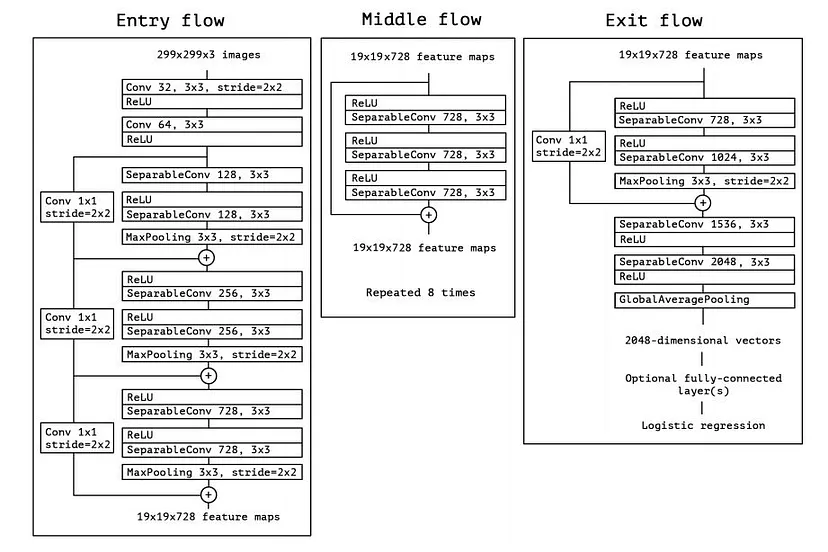

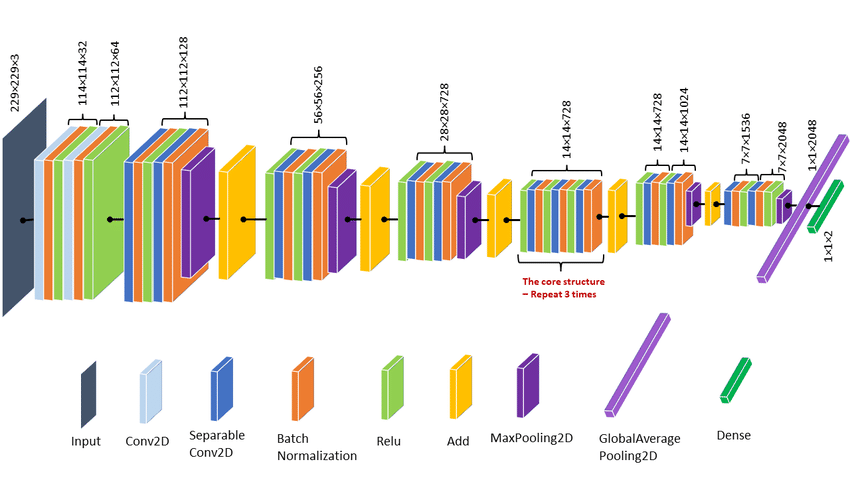

In [631]:
def Block(input_tensor, in_filters, out_filters, reps, strides=1, start_with_relu=True, grow_first=True):
    x = input_tensor
    if out_filters != in_filters or strides != 1:
        residual = Conv2D(out_filters, 1, strides=strides, use_bias=False)(x)
        residual = BatchNormalization()(residual)
    else:
        residual = x
    
    if grow_first:
        x = ReLU()(x)
        x = SeparableConv2D(out_filters, 3, padding='same')(x)
        x = BatchNormalization()(x)
        in_filters = out_filters
    
    for _ in range(reps - 1):
        x = ReLU()(x)
        x = SeparableConv2D(in_filters, 3, padding='same')(x)
        x = BatchNormalization()(x)
    
    if not grow_first:
        x = ReLU()(x)
        x = SeparableConv2D(out_filters, 3, padding='same')(x)
        x = BatchNormalization()(x)
    
    if strides != 1:
        x = MaxPooling2D(3, strides=strides, padding='same')(x)
    
    x = Add()([x, residual])
    return x

In [632]:
data_augmentor = data_augmentor()

In [633]:
def Xception_Const(input_shape,data_augmentor = data_augmentor):
    ''' Define a tf.keras model for binary classification using Xception model
    Arguments:
        image_shape -- Image width,height and channels
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    inputs = tf.keras.Input(shape=input_shape)
        
    # apply data augmentation to the inputs
    x = data_augmentor(inputs)
    print(x.shape)
    
#     x = Reshape((x.shape[1],x.shape[2],x.shape[3],x.shape[4]))
    
    # Entry Flow
    x = Conv2D(filters=32,kernel_size=(3,3),strides = 2)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2D(64,(3,3),padding = 'valid')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Block(x, 64, 128, 2, strides=2, start_with_relu=False, grow_first=True)
    x = Block(x, 128, 256, 2, strides=2, start_with_relu=True, grow_first=True)
    x = Block(x, 256, 728, 2, strides=2, start_with_relu=True, grow_first=True)
    
    
    # Middle Flow
    for _ in range(8):
        x = Block(x, 728, 728, 3, start_with_relu=True, grow_first=True)
    
    # Exit Flow
        
    x = Block(x, 728, 1024, 3,strides=2,start_with_relu=True, grow_first=False)
    
    x = SeparableConv2D(1536,(3,3))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = SeparableConv2D(2048,(3,3))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    
    output_tensor = Dense(1,activation='sigmoid')(x)
    
    
    model = Model(inputs=inputs, outputs=output_tensor)
    return model 
    

In [634]:
input_shape = (299, 299, 3)
model_initial = Xception(input_shape=input_shape, data_augmentor=data_augmentor)

In [635]:
model_initial.compile(optimizer=config.optimizer, loss=config.loss, metrics=[config.metric])

In [636]:
history = model_initial.fit(
    train_generator,
    epochs=config.epoch,
    batch_size=3,
    validation_data=val_generator)
# #     verbose=1,  # Add this line to display progress bars
# #     steps_per_epoch=len(train_generator) // config.batch_size,  # Add this line for accurate progress tracking
# #     validation_steps=len(val_generator) // config.batch_size  # Add this line for accurate validation progress tracking
# )
# # [optional] finish the wandb run, necessary in notebooks
# run.finish()

In [ ]:
model_initial.evaluate(test_generator)

In [641]:
base_model = Xception(input_shape=(299,299,3),include_top=False,weights='imagenet',pooling ='avg')

base_model.summary()


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_91      │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 149, 149,  │        864 │ input_layer_91[0… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 149, 149,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 149, 149,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 147, 147,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 147, 147,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 147, 147,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 147, 147,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 147, 147,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 147, 147,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 147, 147,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 147, 147,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_110 (Conv2D) │ (None, 74, 74,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 74, 74,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 74, 74,    │        512 │ conv2d_110[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_145 (Add)       │ (None, 74, 74,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 74, 74,    │          0 │ add_145[0][0]   

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [642]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

block14_sepconv2_act
global_average_pooling2d_9


In [643]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  133


In [644]:
# Fine-tune from this layer onwards
fine_tune_at = 110

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
x = base_model.output

predicted = Dense(1, activation="sigmoid")(x) 

model = Model(base_model.input,predicted)
    
model.compile(loss=config.loss,
              optimizer = config.optimizer,
              metrics=[config.metric])

history = model.fit(
    train_generator,
    epochs=config.epoch,
    batch_size=config.batch_size,
    validation_data=val_generator,
    callbacks=[
        WandbMetricsLogger(log_freq=5)
    ],
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/358 ━━━━━━━━━━━━━━━━━━━━ 3:44:59 38s/step - accuracy: 0.5000 - loss: 0.7009

I0000 00:00:1718670603.849636     513 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


358/358 ━━━━━━━━━━━━━━━━━━━━ 339s 844ms/step - accuracy: 0.7686 - loss: 0.4507 - val_accuracy: 0.5776 - val_loss: 2.2698
Epoch 2/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 279s 764ms/step - accuracy: 0.9507 - loss: 0.1290 - val_accuracy: 0.6158 - val_loss: 2.8520
Epoch 3/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 277s 760ms/step - accuracy: 0.9691 - loss: 0.0846 - val_accuracy: 0.8099 - val_loss: 0.6258
Epoch 4/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 275s 754ms/step - accuracy: 0.9735 - loss: 0.0712 - val_accuracy: 0.7033 - val_loss: 1.4762
Epoch 5/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 274s 750ms/step - accuracy: 0.9780 - loss: 0.0569 - val_accuracy: 0.9101 - val_loss: 0.2578
Epoch 6/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 274s 750ms/step - accuracy: 0.9812 - loss: 0.0663 - val_accuracy: 0.8942 - val_loss: 0.4916
Epoch 7/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 275s 752ms/step - accuracy: 0.9853 - loss: 0.0423 - val_accuracy: 0.7701 - val_loss: 1.2924
Epoch 8/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 273s 747ms/step - accuracy: 0.9901 - loss: 0.03

In [671]:
model.evaluate(test_generator)

97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - accuracy: 0.8388 - loss: 0.7780


[0.8633807897567749, 0.83564293384552]

In [672]:
model.evaluate(val_generator)

40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 0.8056 - loss: 1.1893


[1.1570945978164673, 0.8042959570884705]

In [ ]:
# test_dataset.class_names

In [ ]:
# test_predictions = tf.argmax(test_predictions,axis=1)

In [ ]:
# test_predictions

In [ ]:
# label = np.concatenate((np.zeros(1541),np.ones(1562)))
# 

In [ ]:
# accuracy = np.mean(test_predictions == label)
# print(f"Test accuracy: {accuracy * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction: 0.0005


'Fake Image with a confidence score of 99.95%'

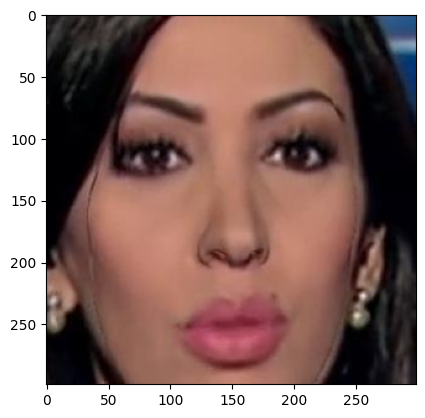

In [670]:
def predict(file_path):
    # Load the image
    img = Image.open(file_path)

    # Preprocess the image
    img = img.resize((299, 299))
    img_array = np.array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    plt.imshow(img_array[0])
    # Make prediction
    prediction = model.predict(img_array)

    # Print prediction
    print(f"Prediction: {prediction[0][0]:.4f}")
    return f"Fake Image with a confidence score of {(1-prediction[0][0]) * 100:.2f}%" if prediction< 0.5 else f"Real Image with a confidence score of {(1 - prediction[0][0]) * 100:.2f}%"

predict('/kaggle/input/faceforensics1600-videospreprocess/data/test/fake/1680_0.jpg')

In [647]:
#  Save the entire model to a file
model.save("model_v3.hdf5")

In [ ]:
# import numpy as np
# from tensorflow.keras.preprocessing import image
# import matplotlib.pyplot as plt

# def predict(file_path, model):
#     # Load and preprocess the image
#     img = image.load_img(file_path, color_mode='rgb', target_size=(299, 299))
    
#     # Convert to array
#     img_array = image.img_to_array(img)
    
#     # If your model was trained on uint8 data:
# #     plt.imshow(np.uint8(img_array))
# #     plt.show()
    
#     # If your model was trained on normalized data:
#     img_array = img_array / 255.0  # Normalize to 0-1 if needed
# #     plt.imshow(img_array)  # No need for uint8 conversion if data is normalized
# #     plt.show()
    
#     # Add batch dimension and predict
#     img_array = np.expand_dims(img_array, axis=0)
#     predictions = model.predict(img_array)
    
#     return predictions

# # Load your trained model
# # model = ...

# # Generate prediction
# prediction = predict('/kaggle/input/faceforensics1600-videospreprocess/data/test/fake/1606_0.jpg', model)
# print(prediction)
